# Imports

In [1]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

In [2]:
from stable_baselines.common import set_global_seeds
from delfi.distribution.mixture.GaussianMixture import MoG
import seaborn as sns
from scipy.spatial import distance
from fabio.MDN import MDNN, MDRFF
from fabio.BayesSim import BayesSim
import warnings
import matplotlib.pyplot as plt
from src.FetchSim import *
import elfi
import scipy
warnings.filterwarnings('ignore')

Using TensorFlow backend.
/home/rafaelpossas/Dev/virtual_environments/py3-tensorflow-gpu/lib/python3.6/site-packages/GPy/util/config.py:28: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/rafaelpossas/Dev/virtual_environments/py3-tensorflow-gpu/lib/python3.6/site-packages/GPy/defaults.cfg' mode='r' encoding='UTF-8'>
  config.readfp(open(default_file))
/home/rafaelpossas/Dev/virtual_environments/py3-tensorflow-gpu/lib/python3.6/site-packages/GPy/util/datasets.py:58: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/rafaelpossas/Dev/virtual_environments/py3-tensorflow-gpu/lib/python3.6/site-packages/GPy/util/data_resources.json' mode='r' encoding='utf-8'>
  json_data = open(path, encoding='utf-8').read()
/home/rafaelpossas/Dev/virtual_environments/py3-tensorflow-gpu/lib/python3.6/site-packages/GPy/util/datasets.py:63: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/rafaelpossas/Dev/virtual_environments/py3-tensorflow-gpu/lib/python3.6/site-packages

# Functions

In [3]:
def identity(y):
    return y
def gen_data_elfi(m, t1, batch_size=1, random_state=None):
    results = []
    for param in t1:
        data = m.gen_single(param)['data']
        results.append(data)

    return np.array(results)

def gen_tests(ntest=10):
    # Number of testing samples
    x_test = np.zeros((stats.shape[1], ntest))

    for i in range(ntest):
        x_test[:, i] = m.gen_single(np.array(true_obs))['data']

    x_test = np.mean(x_test, axis=1)
    return x_test

def get_mdrff(n_components=2, kernel="RBF", sigma=4, nfeat=100, output_dim=None, input_dim=None):
    model = MDRFF(ncomp=n_components, outputd=output_dim, inputd=input_dim, nfeat=nfeat,
                  sigma=sigma, kernel=kernel)
    return model

def get_mdn(n_components=2, nhidden=2, nunits=[24,24], output_dim=None, input_dim=None):
    model = MDNN(ncomp=n_components, outputd=output_dim, inputd=input_dim, nhidden=nhidden, nunits=nunits)
    return model

def predict_mog_from_stats(ntest=1, alpha_pred=None, mu_pred=None,sigma_pred=None, ncomp=None, output_dim=None):
    alpha_pred = np.array(alpha_pred).reshape(-1, ncomp)
    mu_pred = np.array(mu_pred).reshape(-1, ncomp, output_dim)
    sigma_pred = np.array(sigma_pred).reshape(-11, ncomp, output_dim)
    mog = []
    for pt in range(ntest):
        a = alpha_pred[pt, :]
        ms = [mu_pred[pt, i, :] for i in range(ncomp)]
        Ss = []
        di = np.diag_indices(output_dim) #diagonal indices
        for i in range(ncomp):
            tmp = np.zeros((output_dim, output_dim))
            tmp[di] = sigma_pred[pt, i, :]**2
            Ss.append(tmp)
        mog.append(dd.MoG(a=a, ms=ms, Ss=Ss))
    return mog[0]

def plot_posterior(posteriors, n_samples=100, set_limits=False):
    for name, posterior in posteriors:
        if isinstance(posterior, MoG):
            prior_samples = posterior.gen(n_samples=n_samples)
        else:
            prior_samples = posterior.samples_array
        distplot = sns.distplot(np.array(prior_samples).reshape(-1, 1), label=name, hist=False)
        if set_limits:
            distplot.set(xlim=(0, 0.6))
    plt.axvline(0.3, 0, 1.0, color='r', label="True Value")
    plt.title("Distribution over friction coefficient")
    plt.xlabel("Friction")
    plt.legend()
    plt.show()

# Problem Setup

In [ ]:
model_path = "{}/{}/{}.pkl".format(folder, algo, env_id)
model = ALGOS[algo].load(model_path)

In [4]:
set_global_seeds(0)

In [5]:
model_name = "ALL"
policy_file = "logs/FetchPush-v1/random_0.1-1.0_200_epochs/policy_best.pkl"
data = helper.load("prior.pkl")

In [6]:
# Load policy.
with open(policy_file, 'rb') as f:
    policy = pickle.load(f)

Logging to /tmp/openai-2019-02-02-08-17-36-399616
Creating a DDPG agent with action space 4 x 1.0...


In [7]:
# data = load_sims_from_prior()
env_id = "FetchPush-v1"
dim = 4
env = gym.make(env_id)
env_params = ['friction']
p = dd.Uniform(lower=[0.1], upper=[0.6])
true_obs = [0.3]

In [ ]:
s = Identity()
m = FetchSim(dim, policy, env, env_params, data=data)
g = Default(model=m, prior=p, summary=s)
params, stats = g.gen(1)  # necessary for initiliasation

## Generating tests

In [ ]:
x_test = gen_tests()

# Training

In [ ]:
m.toggle_load_from_disk()
models = []
bayes_sim = []
names = []

## Mixture Density Random Fourier Features

In [ ]:
if model_name == "MDRFF" or model_name == "ALL":
    model = get_mdrff(n_components=2,nfeat=100, sigma=4,kernel="Matern52", 
                      output_dim=params.shape[1], input_dim=stats.shape[1])
    inf = BayesSim(generator=g, obs=x_test, model=model)
    log, train_data, _ = inf.run(n_train=100, epochs=900, n_rounds=1)

    models.append(model)
    bayes_sim.append(inf)
    names.append("MDRFF")

In [ ]:
plt.plot(log[0]['loss'])
plt.xlabel('Iteration')
plt.ylabel('Loss')

In [ ]:
tmp_posterior = inf.predict(x_test.reshape(1, -1))
for dim in range(params.shape[1]):
    for k in range(tmp_posterior.ncomp):
        print(r'component {}: mixture weight = {:.4f}; mean = {:.4f}; variance = {:.4f}'.format(
            k + 1, tmp_posterior.a[k], tmp_posterior.xs[k].m[dim], tmp_posterior.xs[k].S[dim][dim]))
plot_posterior([("MDRFF", tmp_posterior)])

## Mixture Density Network

In [ ]:
if model_name == "MDN" or model_name == "ALL":
    model = get_mdn(output_dim=params.shape[1], input_dim=stats.shape[1])
    inf = BayesSim(generator=g, obs=x_test, model=model)
    log, train_data, _ = inf.run(n_train=100, epochs=300, n_rounds=1)

    models.append(model)
    bayes_sim.append(inf)
    names.append("MDN")

In [ ]:
plt.plot(log[0]['loss'])
plt.xlabel('Iteration')
plt.ylabel('Loss');

In [ ]:
tmp_posterior = inf.predict(x_test.reshape(1, -1))

In [ ]:
for dim in range(params.shape[1]):
    for k in range(tmp_posterior.ncomp):
        print(r'component {}: mixture weight = {:.4f}; mean = {:.4f}; variance = {:.4f}'.format(
            k + 1, tmp_posterior.a[k], tmp_posterior.xs[k].m[dim], tmp_posterior.xs[k].S[dim][dim]))

In [ ]:
plot_posterior([("MDN", tmp_posterior)])

## Rejection ABC

In [ ]:
if model_name == "REJ-ABC" or model_name == "ALL":
    t1 = elfi.Prior(scipy.stats.uniform, 0, 1)
    y_obs = gen_data_elfi(m, true_obs)
    sim = elfi.Simulator(gen_data_elfi, m, t1, observed=y_obs)
    S1 = elfi.Summary(identity, sim)
    d = elfi.Distance('euclidean', S1)
    rej = elfi.Rejection(d, batch_size=20000, seed=30052017)

In [ ]:
res = rej.sample(2000, threshold=.3)
models.append(rej)
bayes_sim.append(res)
names.append("REJ-ABC")

In [ ]:
mean = np.mean(res.samples_array)
var = np.var(res.samples_array)
print(r'component 0: mixture weight = 1; mean = {:.4f}; variance = {:.4f}'.format(mean, var))

In [ ]:
plot_posterior([("REJ-ABC", res)])

# Results

In [ ]:
import delfi.distribution as dd


## Reproducing Paper Plot

In [27]:
posteriors = []

====== MDRFF ======<br>
component 1: mixture weight = 0.0093; mean = 0.213; variance = 0.3456<br>
component 2: mixture weight = 0.9907; mean = 0.2873; variance = 0.03<br>

In [28]:
mdrff_mog = predict_mog_from_stats(alpha_pred=[0.0093, 0.9907],
                                   mu_pred=[0.213,0.2873],sigma_pred=[0.3456, 0.03],ncomp=2, output_dim=1)
posteriors.append(("BayesSim RFF", mdrff_mog))

In [29]:
mdrff_mog.eval(np.array([0.3]).reshape(-1,1))

array([2.48953338])

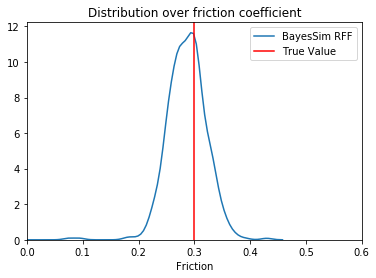

In [30]:
plot_posterior([("BayesSim RFF", mdrff_mog)], n_samples=500, set_limits=True)

====== MDN ======<br>
component 1: mixture weight = 0.9967; mean = 0.2520; variance = 0.049<br>
component 2: mixture weight = 0.0033; mean = 0.4840; variance = 0.179<br>

In [31]:
mdn_mog =  predict_mog_from_stats(alpha_pred=[0.9967, 0.0033], 
                                  mu_pred=[0.2520,0.4840],sigma_pred=[0.049, 0.179],ncomp=2, output_dim=1)
posteriors.append(("ɛ-Free", mdn_mog))

In [32]:
mdn_mog.eval(np.array([0.3]).reshape(-1,1))

array([1.61475395])

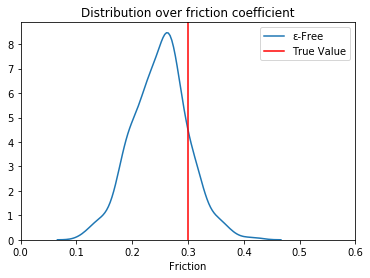

In [33]:
plot_posterior([("ɛ-Free", mdn_mog)], n_samples=500, set_limits=True)

====== Rejection ABC ======<br>
component 0: mixture weight = 1; mean = 0.3284; variance = 0.136

In [34]:
rejabc_mog =  predict_mog_from_stats(alpha_pred=[1], 
                                  mu_pred=[0.3284],sigma_pred=[0.136],ncomp=1, output_dim=1)
posteriors.append(("Rejection ABC", rejabc_mog))

In [35]:
rejabc_mog.eval(np.array([0.3]).reshape(-1,1))

array([1.05435823])

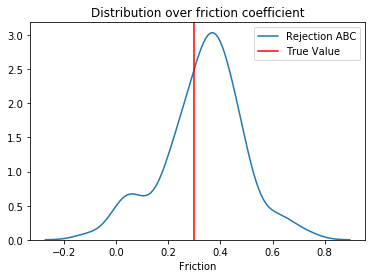

In [36]:
plot_posterior([("Rejection ABC", rejabc_mog)])

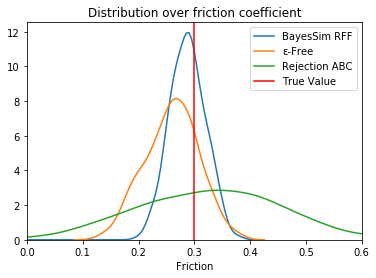

In [42]:
plot_posterior(posteriors,n_samples=500, set_limits=True)

## Plotting current trained Methods

In [ ]:
posteriors = []
for name, md, inf in zip(names, models, bayes_sim):
    if name in ['MDN', "MDRFF"]:
        post = inf.predict(x_test.reshape(1, -1))
    else:
        post = inf
    posteriors.append((name, post))

In [ ]:
for dim in range(params.shape[1]):
    print('Parameter ' + str(dim + 1) + ':')
    for name, posterior in posteriors:
        print("====== {} ======".format(name))
        if name in ['MDN', "MDRFF"]:
            for k in range(posterior.ncomp):
                print(r'component {}: mixture weight = {:.4f}; mean = {:.4f}; variance = {:.4f}'.format(
                    k + 1, posterior.a[k], posterior.xs[k].m[dim], posterior.xs[k].S[dim][dim]))
        else:
            mean = np.mean(posterior.samples_array)
            var = np.var(posterior.samples_array)
            print(r'component 0: mixture weight = 1; mean = {:.4f}; variance = {:.4f}'.format(mean, var))

In [ ]:
plot_posterior(posteriors)

## Fetch Slide

Testing robustness with 12 parameters
Running test 0 of 5
Running test 1 of 5
Running test 2 of 5
Running test 3 of 5
Running test 4 of 5


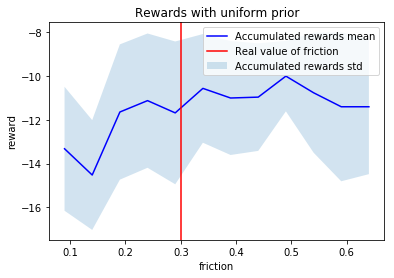

In [8]:
x_plot, y_plot = helper.plot_robustness(policies=[policy], env=env.env, env_params=['friction'], ntests=5, 
                                        distribution=p, true_param=0.3, title="Rewards with uniform prior")

In [9]:
helper.save((x_plot,y_plot), "uniform_push_rewards.pkl")

# Fetch Slide Rewards

In [10]:
uniform_x_plot, uniform_y_plot = helper.load("uniform_push_rewards.pkl")

In [11]:
uniform_mean_y = np.mean(uniform_y_plot, 1)
uniform_std_y = np.std(uniform_y_plot, 1)

In [12]:
posterior_x_plot, posterior_y_plot = helper.load("posterior_push_rewards.pkl")

In [13]:
posterior_mean_y = np.mean(posterior_y_plot, 1)
posterior_std_y = np.std(posterior_y_plot, 1)

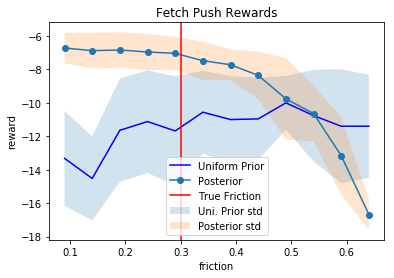

In [17]:
plt.plot(uniform_x_plot, uniform_mean_y, '-b', label=r'Uniform Prior')
plt.fill_between(uniform_x_plot, uniform_mean_y - uniform_std_y, uniform_mean_y + uniform_std_y, 
                 label=r'Uni. Prior std', alpha=0.2)
plt.plot(posterior_x_plot, posterior_mean_y, '-o', label=r'Posterior')
plt.fill_between(posterior_x_plot, posterior_mean_y - posterior_std_y, posterior_mean_y + posterior_std_y, 
                 label=r'Posterior std', alpha=0.2)

plt.axvline(0.3, c='r', label=r'True Friction')
plt.legend(fontsize=10)
plt.axis('on')
plt.xlabel("Friction")
plt.ylabel("reward")
plt.title("Fetch Push Rewards")
plt.xlabel("friction")
plt.show()

In [4]:
results_dict = uniform_x_plot, uniform_y_plot = helper.load("uniform_cartpole_rewards.pkl")
uniform_x_plot_length = results_dict['length']['x_plot']
uniform_y_plot_length = results_dict['length']['y_plot']
uniform_mean_y_length = np.mean(uniform_y_plot_length, 1)
uniform_std_y_legnth = np.std(uniform_y_plot_length, 1)

In [5]:
results_dict = uniform_x_plot, uniform_y_plot = helper.load("posterior_cartpole_rewards.pkl")
posterior_x_plot_length = results_dict['length']['x_plot']
posterior_y_plot_length = results_dict['length']['y_plot']
posterior_mean_y_length = np.mean(posterior_y_plot_length, 1)
posterior_std_y_legnth = np.std(posterior_y_plot_length, 1)

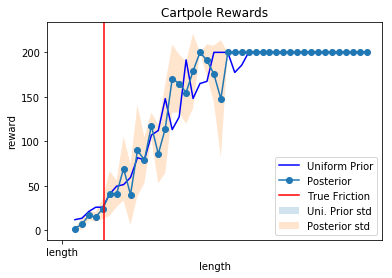

In [7]:
plt.plot(uniform_x_plot_length, uniform_mean_y_length, '-b', label=r'Uniform Prior')
plt.fill_between(uniform_x_plot, uniform_mean_y_length - uniform_std_y_legnth, uniform_mean_y_length + uniform_std_y_legnth, 
                 label=r'Uni. Prior std', alpha=0.2)
plt.plot(posterior_x_plot_length, posterior_mean_y_length, '-o', label=r'Posterior')
plt.fill_between(posterior_x_plot_length, posterior_mean_y_length - posterior_std_y_legnth, posterior_mean_y_length + posterior_std_y_legnth, 
                 label=r'Posterior std', alpha=0.2)

plt.axvline(0.3, c='r', label=r'True Friction')
plt.legend(fontsize=10)
plt.axis('on')
plt.xlabel("Length")
plt.ylabel("reward")
plt.title("Cartpole Rewards")
plt.xlabel("length")
plt.show()